# Characters

EXISTING

This data frame lists all characters, their movie, their gender, and their credit position. The `character_ID` column is later referenced in other data frames.

In [1]:
# import packages
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Loading in the data and basic summary

In [2]:
# creating the df
characters_df = pd.read_csv('./data/movie_characters_metadata.txt', sep='\s+\+\+\+\$\+\+\+\s?',
                            names = ['character_ID', 'character_name', 'movie_ID', 'movie_title', 'gender', 'credit_position'], 
                            dtype='string', engine='python', encoding='ISO-8859-1')

The data was all separated with ' +++$+++ ' and did not have column names. The README described what each column was in the data so I used that to create column names. Where logical, I made the index of the df the initial ID column.

In [3]:
characters_df.shape

(9035, 6)

In [4]:
characters_df.info()
# some characters are unnamed, I will drop them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9035 entries, 0 to 9034
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   character_ID     9035 non-null   string
 1   character_name   9033 non-null   string
 2   movie_ID         9035 non-null   string
 3   movie_title      9035 non-null   string
 4   gender           9035 non-null   string
 5   credit_position  9035 non-null   string
dtypes: string(6)
memory usage: 423.6 KB


In [5]:
characters_df = characters_df.dropna()

In [6]:
characters_df.head()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


In [7]:
characters_df.tail()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
9030,u9030,DURNFORD,m616,zulu dawn,?,?
9031,u9031,MELVILL,m616,zulu dawn,?,?
9032,u9032,NORRIS-NEWMAN,m616,zulu dawn,?,?
9033,u9033,STUART SMITH,m616,zulu dawn,?,?
9034,u9034,VEREKER,m616,zulu dawn,?,?


Some gender makers are missing for characters in this dataframe, I will work on filling in the missing data.

In [8]:
# how many characters are missing gender?
characters_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title,credit_position
gender,,,,,
?,6018,6018,6018,6018,6018
F,45,45,45,45,45
M,150,150,150,150,150
f,921,921,921,921,921
m,1899,1899,1899,1899,1899


Looks like a lot of missing gender markers! Looks like some of the flags are inconsist too, there is 'm' and 'M.'

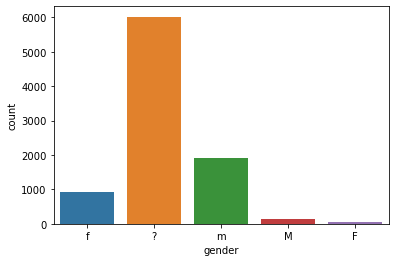

In [9]:
sns.countplot(x = "gender",
             data = characters_df)
plt.show()

More characters are missing gender markers than have gender markers.

In [10]:
# making all gender markers uppercase
characters_df['gender'] = characters_df.gender.map(lambda x: re.sub(r'f', r'F', x))
characters_df['gender'] = characters_df.gender.map(lambda x: re.sub(r'm', r'M', x))

In [11]:
characters_df.describe()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
count,9033,9033,9033,9033,9033,9033
unique,9033,5355,617,617,3,57
top,u0,MAN,m289,casino,?,?
freq,1,44,44,44,6018,6354


In [12]:
# now that the markers are tidied up, let's look again
characters_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title,credit_position
gender,,,,,
?,6018,6018,6018,6018,6018
F,966,966,966,966,966
M,2049,2049,2049,2049,2049


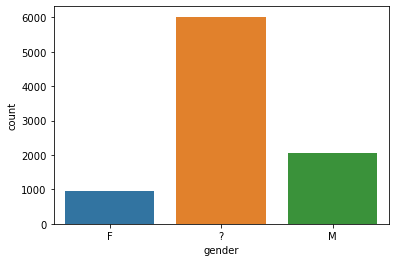

In [13]:
sns.countplot(x = "gender",
             data = characters_df)
plt.show()

A majority of the characters are missing gender markers. I will fill in as many of these as I can.

## Generating gender markers

In [14]:
# df for characters without gender markers
characters_ng1_df = characters_df[characters_df.gender == '?']

# df for characters with gender markers, these will get remerged later
characters_g1_df = characters_df[characters_df.gender != '?']

In [15]:
characters_ng1_df.info()
# a total of 6018 characters without gender

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6018 entries, 1 to 9034
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   character_ID     6018 non-null   string
 1   character_name   6018 non-null   string
 2   movie_ID         6018 non-null   string
 3   movie_title      6018 non-null   string
 4   gender           6018 non-null   object
 5   credit_position  6018 non-null   string
dtypes: object(1), string(5)
memory usage: 329.1+ KB


I will use the NLTK names list and specific strings to help fill in missing gender markers.

### NLTK names

In [16]:
# I will use the names corpus from NLTK to fill in some gaps in gender data
names = nltk.corpus.names
male_names = names.words('male.txt')
female_names = names.words('female.txt')

In [17]:
male_names[:5]

['Aamir', 'Aaron', 'Abbey', 'Abbie', 'Abbot']

In [18]:
female_names[:5]

['Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi']

Some names appear on both lists, this will be addressed below. I will add a gender marker 'A' for ambiguous, the names in both lists as well as certain strings will make up this category.

### Strings

Miss Perky is a character, turns out there are numerous other characters with honorifics and stereotypically gendered words (boy, girl, brother, sister, etc.). These can be seen in the function below.

### Gender function

In [19]:
# code created by Na-Rae Han and refined by me
def getGender1(name):
    nltkname_m = set([n.upper() for n in male_names])
    nltkname_f = set([n.upper() for n in female_names])
    nltkname_mf = nltkname_m.intersection(nltkname_f)
    name = name.upper()  # uppercase incoming name
    if name in nltkname_mf: return 'A'
    elif name in nltkname_f: return 'F'
    elif name in nltkname_m: return 'M'
    # these strings come from extensive searching through the character names
    elif re.match(r'(.* ?)?(\bMAN\b|BOYFRIEND|DAD|\bPA\b|FATHER|GRANDFATHER|GRANDDAD|GRANDPA|GRAMPA|GRANDSON|BROTHER|BOY|SIR|MR.|MISTER|UNCLE|MALE|\bHERR\b|HOST\b|LORD|PRIEST|COUNT|WIZARD|EMPEROR|GOVERNOR|DUDE|GUY|GROOM|BUTLER)', name):
        return 'M'
    elif 'WOMAN' in name or re.match(r'(.* ?)?(MS\.|MISS\b|GIRL|WIFE|MOM|MUM|MOTHER|DAUGHTER|SISTER|MRS.|AUNT|MAMA|\bMA|LADY|\bFEMALE|FRAU|PRINCESS|QUEEN|GRANDMA|GRANDMOTHER|WAITRESS|HOSTESS|NUN|WITCH|ACTRESS|GOVERNESS|STEWARDESS|CHICK|MAID)', name): 
        return 'F'
    # there are gender assumptions for many of these terms, but I am trying to avoid stereotypes
    elif re.match(r'(.* ?)?(DR. |DR |DOCTOR|DOC|PROFESSOR|PROF.\b|TEACHER|JUDGE|PILOT|LAWYER|KID|CHILD|GUARD|OFFICER|PERSON|COP|SECRETARY|SOLDIER|^VOICE|PASTOR|DETECTIVE$|DET.|DEPUTY|CAPTAIN$|MINISTER|ATTENDANT|CLERK|RECEPTIONIST|NURSE|STUDENT|BARTENDER|CUSTOMER|DRIVER|POLICE)', name): 
        return 'A'
    else:
        return 'unknown'

In [20]:
characters_ng1_df['gender'] = characters_ng1_df['character_name'].map(getGender1)

<ipython-input-20-e52a6c1fafd9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_ng1_df['gender'] = characters_ng1_df['character_name'].map(getGender1)


In [21]:
characters_ng1_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title,credit_position
gender,,,,,
A,908,908,908,908,908
F,1080,1080,1080,1080,1080
M,1569,1569,1569,1569,1569
unknown,2461,2461,2461,2461,2461


Initially 6018 characters were missing gender markers.
* Just NLTK: 2229
* NLTK + initial strings: 2883
* 2nd pass: 2894
* 3rd pass: 2907 
* 4th pass: 2920
* 5th pass: 3062
* 6th pass 3122
* 7th pass: 3136
* 8th pass: 3141
* 9th pass: 3177
* 10th pass: 3193
* 11th pass: 3278
* 12th pass: 3349
* 13th pass: 3368
* 14th pass: 3400
* 15th pass: 3526
* 16th pass: 3557

Over 1300 added just by strings!

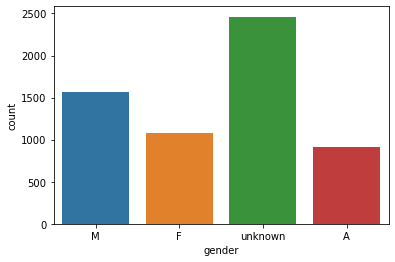

In [22]:
sns.countplot(x = "gender",
             data = characters_ng1_df)
plt.show()
# still a lot of unknown genders, but more than half were resolved

## Another pass at gender markers: identifying first names

One of the last characters in the dataframe is "Stuart Smith" which made me think about split the `character_name` column to see if NLTK names would work on first names.

In [23]:
# df for characters without gender markers
characters_ng2_df = characters_ng1_df[characters_ng1_df.gender == 'unknown']

# df for characters with gender markers, these will get remerged later
characters_g2_df = characters_ng1_df[characters_ng1_df.gender != 'unknown']

In [24]:
characters_ng2_df.head()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
13,u13,AROJAZ,m1,1492: conquest of paradise,unknown,?
15,u15,BOBADILLA,m1,1492: conquest of paradise,unknown,?
20,u20,MENDEZ,m1,1492: conquest of paradise,unknown,?
21,u21,MOXICA,m1,1492: conquest of paradise,unknown,?
22,u22,PINZON,m1,1492: conquest of paradise,unknown,?


In [25]:
characters_g2_df.head()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
1,u1,BRUCE,m0,10 things i hate about you,M,?
3,u3,CHASTITY,m0,10 things i hate about you,F,?
8,u8,MISS PERKY,m0,10 things i hate about you,F,?
10,u10,SHARON,m0,10 things i hate about you,F,?
12,u12,ALONSO,m1,1492: conquest of paradise,M,?


In [26]:
# some characters are named like "Chuck/Captain" so I will also split by /
# some characters are named like "Helen's Voice" so I will split by '
characters_ng2_df['split_name'] = characters_ng2_df.character_name.map(lambda x: re.split("/| |'", x))

<ipython-input-26-1102011c8835>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_ng2_df['split_name'] = characters_ng2_df.character_name.map(lambda x: re.split("/| |'", x))


In [27]:
# modifying the function above to look at just the first item in the list
def getGender2(name):
    nltkname_m = set([n.upper() for n in male_names])
    nltkname_f = set([n.upper() for n in female_names])
    nltkname_mf = nltkname_m.intersection(nltkname_f)
    name = name[0].upper()  # uppercase incoming name
    if name in nltkname_mf: return 'A'
    elif name in nltkname_f: return 'F'
    elif name in nltkname_m: return 'M'
    else:
        return 'unknown'

In [28]:
characters_ng2_df['gender'] = characters_ng2_df['split_name'].map(getGender2)

<ipython-input-28-d26d63e36a8e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_ng2_df['gender'] = characters_ng2_df['split_name'].map(getGender2)


In [29]:
characters_ng2_df.tail()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position,split_name
9030,u9030,DURNFORD,m616,zulu dawn,unknown,?,[DURNFORD]
9031,u9031,MELVILL,m616,zulu dawn,unknown,?,[MELVILL]
9032,u9032,NORRIS-NEWMAN,m616,zulu dawn,unknown,?,[NORRIS-NEWMAN]
9033,u9033,STUART SMITH,m616,zulu dawn,M,?,"[STUART, SMITH]"
9034,u9034,VEREKER,m616,zulu dawn,unknown,?,[VEREKER]


In [30]:
characters_ng2_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title,credit_position,split_name
gender,,,,,,
A,48,48,48,48,48,48
F,44,44,44,44,44,44
M,108,108,108,108,108,108
unknown,2261,2261,2261,2261,2261,2261


Added another 200 gender markers.

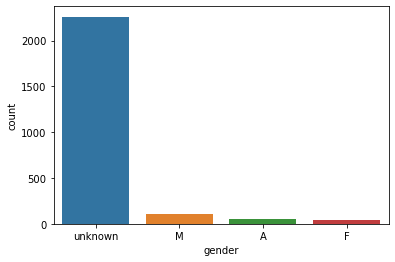

In [31]:
sns.countplot(x = "gender",
             data = characters_ng2_df)
plt.show()
# still majority unknown, but a small bump for the other markers.

Some character's first names come second in the list of split names, like "Detective Neal"

In [32]:
# separate the dfs again

# df for characters without gender markers
characters_ng3_df = characters_ng2_df[characters_ng2_df.gender == 'unknown']

# df for characters with gender markers, these will get remerged later
characters_g3_df = characters_ng2_df[characters_ng2_df.gender != 'unknown']

In [33]:
characters_ng3_df.head()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position,split_name
13,u13,AROJAZ,m1,1492: conquest of paradise,unknown,?,[AROJAZ]
15,u15,BOBADILLA,m1,1492: conquest of paradise,unknown,?,[BOBADILLA]
20,u20,MENDEZ,m1,1492: conquest of paradise,unknown,?,[MENDEZ]
21,u21,MOXICA,m1,1492: conquest of paradise,unknown,?,[MOXICA]
22,u22,PINZON,m1,1492: conquest of paradise,unknown,?,[PINZON]


In [34]:
characters_g3_df.head()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position,split_name
43,u43,ROBERT HAWKINS,m2,15 minutes,M,?,"[ROBERT, HAWKINS]"
46,u46,STEPHEN GELLER,m2,15 minutes,M,?,"[STEPHEN, GELLER]"
148,u148,MEL GORDON,m10,affliction,A,?,"[MEL, GORDON]"
239,u239,VAN LEUWEN,m15,aliens,A,?,"[VAN, LEUWEN]"
267,u267,VON STRACK,m16,amadeus,M,?,"[VON, STRACK]"


In [35]:
def getGender3(name):
    nltkname_m = set([n.upper() for n in male_names])
    nltkname_f = set([n.upper() for n in female_names])
    nltkname_mf = nltkname_m.intersection(nltkname_f)
    if len(name) > 1:
        name = name[1].upper()  # uppercase incoming name
        if name in nltkname_mf: return 'A'
        elif name in nltkname_f: return 'F'
        elif name in nltkname_m: return 'M'
        else:
            return 'unknown'
    else:
        return 'unknown'

In [36]:
characters_ng3_df['gender'] = characters_ng3_df['split_name'].map(getGender3)

<ipython-input-36-fb80d17392ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_ng3_df['gender'] = characters_ng3_df['split_name'].map(getGender3)


In [37]:
characters_ng3_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title,credit_position,split_name
gender,,,,,,
A,20,20,20,20,20,20
F,9,9,9,9,9,9
M,73,73,73,73,73,73
unknown,2159,2159,2159,2159,2159,2159


Added another 102 gender markers.

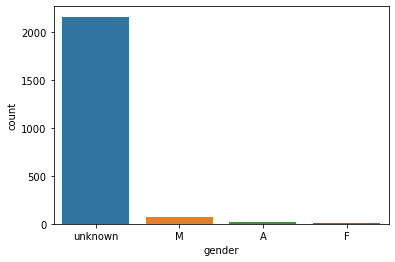

In [38]:
sns.countplot(x = "gender",
             data = characters_ng3_df)
plt.show()
# smaller progress than the first pass, but still some progress

## Remerging the dataframes

In [39]:
# now that I have made progress on adding gender markers, I will add the dataframes back together
characters_update_df = pd.concat([characters_g1_df, characters_g2_df, characters_g3_df, characters_ng3_df])

In [40]:
characters_update_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title,credit_position,split_name
gender,,,,,,
A,976,976,976,976,976,68
F,2099,2099,2099,2099,2099,53
M,3799,3799,3799,3799,3799,181
unknown,2159,2159,2159,2159,2159,2159


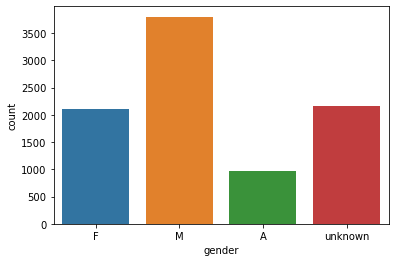

In [41]:
# updated dataframe gender breakdown
sns.countplot(x = "gender",
             data = characters_update_df)
plt.show()

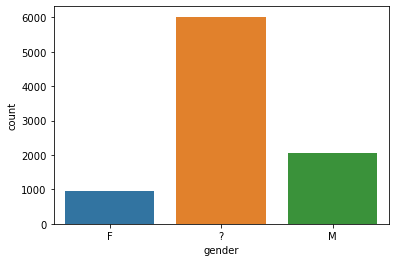

In [42]:
# compared to the original dataframe! huge improvement, I was able to cut the unknown gender markers down by half
sns.countplot(x = "gender",
             data = characters_df)
plt.show()

## Pickling the data and creating a csv

In [43]:
import pickle

In [44]:
# pickle the data to use in other notebooks for further analysis
f = open('characters_update_df.pkl', 'wb')
pickle.dump(characters_update_df, f, -1)
f.close()

In [45]:
characters_update_df.to_csv('./new_data/characters_df.csv', header=True)